# Multiple linear regression & gradient descent

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# As a solution to ordinary least squares minimization


The simple linear regression model
\begin{align}
y = w_0 + \sum_{i>0} w_ih_i(\underline x) + \epsilon
\end{align}

can be upgraded to a vector-valued case:

\begin{align}
y_j = w_0 + \sum_{i>0}^p w_ih_i(\underline x_j) + \epsilon_j \ , \ j =1,\dots,n \ .
\end{align}

The above can be written in matrix notation as

\begin{align}
\underline y = H(\underline x) \underline w + \underline\epsilon \ ,
\end{align}

where $H_{ji} = h_i(x_j)$, and $H_{j0} = \underline 1$. We will drop the underlines from now on.

The linear regression model can be obtained as a solution to the ordinary least squares functional (also called residual sum of squares):

\begin{align}
RSS(w) = (y - Hw)^t (y -Hw) \ ,
\end{align}

and its gradient is
\begin{align}\label{rss1}
\nabla RSS(w) = -2H^t (y - Hw) .
\end{align}

To obtain (\ref{rss1}),

\begin{align}
\partial_{w^m}RSS(w) & = \partial_{w^m}(y - Hw)^t (y -Hw)\\
 & = \partial_{w^m}(y^i - (Hw)^i)\delta_{ij} (y^j - (Hw)^j) \\
 & = \partial_{w^m}(y^i - H^i_{\ k}w^k)\delta_{ij} (y^j - H^j_{\ l}w^l) \\
  & = - 2 H_{im} (y^i - H^i_{\ l}w^l) \\
    & = - 2 H^t_{mi} (y^i - H^i_{\ l}w^l) \\
        & = - 2 H^t (y - Hw).
\end{align}

The solution to $\nabla RSS(w) = 0$ is then,
\begin{align}
\hat w = \left( H^tH \right)^{-1} H^ty \ .
\end{align}

The above solution exists $\iff$ $H$ is invertible $\iff$ $n \geq p + 1 $ ($H$ is an $x \times (p+1)$ matirx.  


# Assumptions on linear regression model

- Linearity: The mean of the response variable is a linear combination of the parameters (regression coefficients) and the predictor variables.

- Independence of errors: The errors of the response variables are uncorrelated with each other.

- Homoscedasticity (constant variance) of the errors: The variance of the errors is constant with respect to the predicting   variables or the response.

- No linear dependence between the predicting variables.

- This assumption may not be met, that is, one can perform linear regression without it: the errors are drawn from a normal distribution.

Related to the last point: if there are outliers in the distribution of the residuals, it might help to go back and model the problem after excluding such outliers.

In [35]:
import graphlab
import matplotlib.pyplot as plt
graphlab.canvas.set_target('ipynb')

### Example using housing data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [92]:
sales = graphlab.SFrame('/Users/cabrera/Documents/10_python_coding/206_regression/kc_house_data.gl/') 

Need to change `zipcode` column to integer type.

In [93]:
sales['zipcode'] = sales['zipcode'].astype(int)

Split into training and testing sets:

In [94]:
train_data,test_data = sales.random_split(.8,seed=0)

Fuction to compute residual sum of squares

In [6]:
def get_residual_sum_of_squares(model, data, outcome):
# returns (y - y_pred)*(y - y_pred)

    predictions = model.predict(data)
    RSS = ((outcome - predictions)**2).sum()

    return(RSS)    

## Creating some new features

We often think of multiple regression as including multiple different features (e.g. # of bedrooms, squarefeet, and # of bathrooms) but we can also consider transformations of existing features e.g. the log of the squarefeet or even "interaction" features such as the product of bedrooms and bathrooms.

Here we use the logarithm function to create a new feature. so first you should import it from the math library.

In [7]:
from math import log

Next we create the following 4 new features as column in both TEST and TRAIN data:
* bedrooms_squared = bedrooms\*bedrooms
* bed_bath_rooms = bedrooms\*bathrooms
* log_sqft_living = log(sqft_living)
* lat_plus_long = lat + long 
As an example here's the first one:

In [95]:
train_data.head(3)

Columns:
	id	str
	date	datetime
	price	float
	bedrooms	float
	bathrooms	float
	sqft_living	float
	sqft_lot	int
	floors	str
	waterfront	int
	view	int
	condition	int
	grade	int
	sqft_above	int
	sqft_basement	int
	yr_built	int
	yr_renovated	int
	zipcode	int
	lat	float
	long	float
	sqft_living15	float
	sqft_lot15	float

Rows: 3

Data:
+------------+---------------------------+----------+----------+-----------+
|     id     |            date           |  price   | bedrooms | bathrooms |
+------------+---------------------------+----------+----------+-----------+
| 7129300520 | 2014-10-13 00:00:00+00:00 | 221900.0 |   3.0    |    1.0    |
| 6414100192 | 2014-12-09 00:00:00+00:00 | 538000.0 |   3.0    |    2.25   |
| 5631500400 | 2015-02-25 00:00:00+00:00 | 180000.0 |   2.0    |    1.0    |
+------------+---------------------------+----------+----------+-----------+
+-------------+----------+--------+------------+------+-----------+-------+------------+
| sqft_living | sqft_lot | floors | waterfront | view | condition | grade | sqft_above |
+-------------+----------+--------+------------+------+-----------+-------+------------+
|    1180.0   |   5650   |   1    |     0      |  0   |     3     |   7   |    1180    |
|    2570.0   |   7242   |   2    |     0      |  0   |     3     |   7   |    2170    |
|    770.0    |  10000   |   1    |     0      |  0   |     3     |   6   |    770     |
+-------------+----------+--------+------------+------+-----------+-------+------------+
+---------------+----------+--------------+---------+-------------+
| sqft_basement | yr_built | yr_renovated | zipcode |     lat     |
+---------------+----------+--------------+---------+-------------+
|       0       |   1955   |      0       |  98178  | 47.51123398 |
|      400      |   1951   |     1991     |  98125  | 47.72102274 |
|       0       |   1933   |      0       |  98028  | 47.73792661 |
+---------------+----------+--------------+---------+-------------+
+---------------+---------------+-----+
|      long     | sqft_living15 | ... |
+---------------+---------------+-----+
| -122.25677536 |     1340.0    | ... |
|  -122.3188624 |     1690.0    | ... |
| -122.23319601 |     2720.0    | ... |
+---------------+---------------+-----+
[3 rows x 21 columns]

In [96]:
train_data['bedrooms_squared'] = train_data['bedrooms'].apply(lambda x: x**2)
test_data['bedrooms_squared'] = test_data['bedrooms'].apply(lambda x: x**2)

train_data['bed_bath'] = train_data['bedrooms']*train_data['bathrooms']
test_data['bed_bath'] = test_data['bedrooms']*test_data['bathrooms']

train_data['log_sqft_living']  = train_data['sqft_living'].apply(lambda x: log(x))
test_data['log_sqft_living']  = test_data['sqft_living'].apply(lambda x: log(x))

train_data['lat+long'] = train_data['lat'] + train_data['long']
test_data['lat+long'] = test_data['lat'] + test_data['long']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this feature will mostly affect houses with many bedrooms.
* bedrooms times bathrooms gives what's called an "interaction" feature. It is large when *both* of them are large.
* Taking the log of squarefeet has the effect of bringing large values closer together and spreading out small values.
* Adding latitude to longitude is totally non-sensical but we will do it anyway (you'll see why)

### Checking linearity between features and target variable

Before modeling we check that the target column (price) is linear with respect the attributes. We will plot here just four sample scatter plots.

In [97]:
train_data.column_names()

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'bedrooms_squared',
 'bed_bath',
 'log_sqft_living',
 'lat+long']

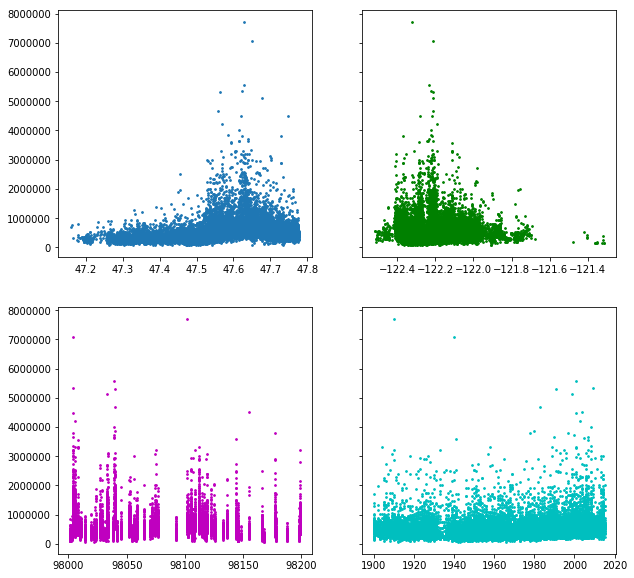

In [101]:

f, ax = plt.subplots(2,2,figsize=(10,10),squeeze=True, sharey=True,sharex=False)
ax[0,0].scatter(train_data['lat'],train_data['price'],s=3)
ax[0,1].scatter(train_data['long'],train_data['price'],s=3,c='g')
ax[1,0].scatter(train_data['zipcode'],train_data['price'],s=3,c='m')
ax[1,1].scatter(train_data['yr_built'],train_data['price'],s=3,c='c')
f.show()


## Learning Multiple Models

Now we will learn the weights for three (nested) models for predicting house prices. The first model will have the fewest features the second model will add one more feature and the third will add a few more:
* Model 1: squarefeet, # bedrooms, # bathrooms, latitude & longitude
* Model 2: add bedrooms\*bathrooms
* Model 3: Add log squarefeet, bedrooms squared, and the (nonsensical) latitude + longitude

In [10]:
model_1_features = ['sqft_living', 'bedrooms', 'bathrooms', 'lat', 'long']
model_2_features = model_1_features + ['bed_bath']
model_3_features = model_2_features + ['bedrooms_squared', 'log_sqft_living', 'lat+long']

Now that we have the features, we learn the weights for the three different models for predicting target = 'price' using graphlab.linear_regression.create() and look at the value of the weights/coefficients:

In [11]:
# Learn the three models: (don't forget to set validation_set = None)

model1 = graphlab.linear_regression.create(train_data,target='price',features=model_1_features,validation_set=None,verbose=False)
model2 = graphlab.linear_regression.create(train_data,target='price',features=model_2_features,validation_set=None,verbose=False)
model3 = graphlab.linear_regression.create(train_data,target='price',features=model_3_features,validation_set=None,verbose=False)


In [12]:
# Examine/extract each model's coefficients:

print model1.get('coefficients')
print model2.get('coefficients')
print model3.get('coefficients')


+-------------+-------+----------------+---------------+
|     name    | index |     value      |     stderr    |
+-------------+-------+----------------+---------------+
| (intercept) |  None | -56140675.7444 | 1649985.42028 |
| sqft_living |  None | 310.263325778  | 3.18882960408 |
|   bedrooms  |  None | -59577.1160682 | 2487.27977322 |
|  bathrooms  |  None | 13811.8405418  | 3593.54213297 |
|     lat     |  None | 629865.789485  | 13120.7100323 |
|     long    |  None | -214790.285186 | 13284.2851607 |
+-------------+-------+----------------+---------------+
[6 rows x 4 columns]

+-------------+-------+----------------+---------------+
|     name    | index |     value      |     stderr    |
+-------------+-------+----------------+---------------+
| (intercept) |  None | -54410676.1152 | 1650405.16541 |
| sqft_living |  None | 304.449298057  | 3.20217535637 |
|   bedrooms  |  None | -116366.043231 | 4805.54966546 |
|  bathrooms  |  None | -77972.3305135 | 7565.05991091 |
|     lat

### Comparing multiple models

Now that we've learned three models and extracted the model weights we want to evaluate which model is best.

W compute the RSS on TRAINING Data for each of the three models.

In [15]:
# Compute the RSS on TRAINING data for each of the three models and record the values:

rss_model1_train = get_residual_sum_of_squares(model1, train_data, train_data['price'])
rss_model2_train = get_residual_sum_of_squares(model2, train_data, train_data['price'])
rss_model3_train = get_residual_sum_of_squares(model3, train_data, train_data['price'])

print 'rss 1 train', rss_model1_train
print 'rss 2 train', rss_model2_train
print 'rss 3 train', rss_model3_train

rss 1 train 9.71328233544e+14
rss 2 train 9.61592067856e+14
rss 3 train 9.05276314555e+14


Now we compute the RSS on on TEST data for each of the three models.

In [16]:
# Compute the RSS on TESTING data for each of the three models and record the values:

rss_model1_test = get_residual_sum_of_squares(model1, test_data, test_data['price'])
rss_model2_test = get_residual_sum_of_squares(model2, test_data, test_data['price'])
rss_model3_test = get_residual_sum_of_squares(model3, test_data, test_data['price'])

print 'rss 1 test', rss_model1_test
print 'rss 2 test', rss_model2_test
print 'rss 3 test', rss_model3_test

rss 1 test 2.26568089093e+14
rss 2 test 2.24368799994e+14
rss 3 test 2.51829318952e+14


## Gradient decent approach to multiple regression

In [17]:
import numpy as np

In [18]:
def get_numpy_data(data_sframe, features, output):
    # to get data from features and output in numpy arrays
    data_sframe['constant'] = 1 
    features = ['constant'] + features 
   
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    output_array = output_sarray.to_numpy()
    
    return(feature_matrix, output_array)

In [19]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') # the [] around 'sqft_living' makes it a list
print example_features[0,:] # this accesses the first row of the data the ':' indicates 'all columns'
print example_output[0] # and the corresponding output

[1.00e+00 1.18e+03]
221900.0


Using weights:

In [20]:
my_weights = np.array([1., 1.]) # the example weights
my_features = example_features[0,] # we'll use the first data point
predicted_value = np.dot(my_features, my_weights)
print predicted_value

1181.0


In [21]:
def predict_output(feature_matrix, weights):
    predictions = np.dot(feature_matrix,weights)

    return(predictions)

In [22]:
test_predictions = predict_output(example_features, my_weights)
print test_predictions[0] # should be 1181.0
print test_predictions[1] # should be 2571.0

1181.0
2571.0


## Computing the derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output.

Since the derivative of a sum is the sum of the derivatives we can compute the derivative for a single data point and then sum over data points. We can write the squared difference between the observed output and predicted output for a single point as follows:

(w[0]\*[CONSTANT] + w[1]\*[feature_1] + ... + w[i] \*[feature_i] + ... +  w[k]\*[feature_k] - output)^2

Where we have k features and a constant. So the derivative with respect to weight w[i] by the chain rule is:

2\*(w[0]\*[CONSTANT] + w[1]\*[feature_1] + ... + w[i] \*[feature_i] + ... +  w[k]\*[feature_k] - output)\* [feature_i]

The term inside the paranethesis is just the error (difference between prediction and output). So we can re-write this as:

2\*error\*[feature_i] 

That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself. In the case of the constant then this is just twice the sum of the errors!

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors. 

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).

In [23]:
def feature_derivative(errors, feature):
    
    import numpy as np
    
    der = 2* (np.dot(errors,feature))

    return(der)

In [24]:
#testing the above
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([0., 0.]) # this makes all the predictions 0
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors in this case is just the -example_output
feature = example_features[:,0] # let's compute the derivative with respect to 'constant', the ":" indicates "all rows"

derivative = feature_derivative(errors,feature)
print derivative

print -np.sum(example_output)*2 # should be the same as derivative

-23345850022.0
-23345850022.0


## Gradient descent


Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. We define this by requiring that the magnitude (length) of the gradient vector to be smaller than a fixed 'tolerance'.

In [25]:
from math import sqrt

In [26]:
def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance):
    converged = False 
    weights = np.array(initial_weights) # make sure it's a numpy array
    while not converged:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix,weights)

        # compute the errors as predictions - output
        errors = predictions - output
        
        gradient_sum_squares = 0 # initialize the gradient sum of squares
        
        # while we haven't reached the tolerance yet, update each feature's weight
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:, i] is the feature column associated with weights[i]
            # compute the derivative for weight[i]:
            derivative = feature_derivative(errors, feature_matrix[:,i])
            

            # add the squared value of the derivative to the gradient sum of squares (for assessing convergence)
            gradient_sum_squares += derivative*derivative

            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - step_size*derivative
            
        # compute the square-root of the gradient sum of squares to get the gradient magnitude:
        gradient_magnitude = sqrt(gradient_sum_squares)
        if gradient_magnitude < tolerance:
            converged = True
    return(weights)

## Running the Gradient Descent as Simple Regression

In [27]:
train_data,test_data = sales.random_split(.8,seed=0)

Although the gradient descent is designed for multiple regression since the constant is now a feature we can use the gradient descent function to estimat the parameters in the simple regression on squarefeet. The following cell sets up the feature_matrix, output, initial weights and step size for the first model:

In [28]:
# let's test out the gradient descent
simple_features = ['sqft_living']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
initial_weights = np.array([-47000., 1.])
step_size = 7e-12
tolerance = 2.5e7

In [29]:
updated_weight_simple = regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, tolerance)
print updated_weight_simple

[-46999.88716555    281.91211912]


To get predictions:

In [30]:
(simple_feature_matrix_test, output_test) = get_numpy_data(test_data, simple_features, my_output)
predict_output(simple_feature_matrix_test, updated_weight_simple)

array([356134.44317093, 784640.86422788, 435069.83652353, ...,
       663418.65300782, 604217.10799338, 240550.4743332 ])

## Running a multiple regression

In [31]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix_2, output) = get_numpy_data(train_data, model_features, my_output)
initial_weights = np.array([-100000., 1., 1.])
step_size = 4e-12
tolerance = 1e9

In [32]:
updated_weight_2= regression_gradient_descent(feature_matrix_2, output, initial_weights, step_size, tolerance)
print updated_weight_2

[-9.99999688e+04  2.45072603e+02  6.52795277e+01]


In [33]:
(feature_matrix_2_test, output_test) = get_numpy_data(test_data, model_features, my_output)
predict_output(feature_matrix_2_test, updated_weight_2)

array([366651.41203656, 762662.39786164, 386312.09499712, ...,
       682087.39928241, 585579.27865729, 216559.20396617])

In [34]:
test_data['price'].head(3)

dtype: float
Rows: 3
[310000.0, 650000.0, 233000.0]

In [35]:
def rss2(feature_matrix, weights,output):
    
    prediction = predict_output(feature_matrix, weights)
    error = prediction - output
    
    return (np.dot(error, error))

In [36]:
print rss2(simple_feature_matrix,updated_weight_simple,output)
print rss2(feature_matrix_2, updated_weight_2,output)

1201918394833304.0
1186978098009575.8
